In [1]:
from import_data import * # makes df_train_with_labels, and df_test_last
from constants import *
from CRPS import *
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')

# set up parameters based on A4 paper
plt.rcParams.update({
    "savefig.dpi": 300,
    "font.size": 10,  # Font size for text (like in the report)
    # "axes.labelsize": 8,  # Font size for x-axis labels
})


## Tuning the Gradeint boosting with grid search

In [2]:
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

def search_best_params():
    """
    Function to search for the best hyperparameters for GradientBoostingRegressor
    This function takes a lot of time to run
    """
    
    print(f"Starting GridSearchCV with GradientBoostingRegressor to find the best hyperparameters.")
    shuffled_cv = GroupShuffleSplit(
            n_splits = 5,
            test_size = 2/100, # 2 of the 100 engines
            random_state = 42
    )
    param_grid = {
    "n_estimators":   [100, 200, 400],
    
    "learning_rate":  [0.10, 0.125, 0.15,],
    
    "max_depth":      [3, 4, 5],
    
    "min_samples_split": [1, 2, 5],
    "min_samples_leaf":  [1, 2, 5],
    "max_features":   [None, "sqrt", "log2"],

    "subsample":      [0.8, 0.9, 1.0],

    "loss":           ["squared_error"]
    }
    
    print(f"Using the following hyperparameter grid for GradientBoostingRegressor:\n{param_grid}")
    
    # Base GradientBoostingRegressor
    GBR_search = GradientBoostingRegressor(
        random_state=42,
        verbose=3,
        n_iter_no_change=2  # Early stopping
    )
    
    # GridSearchCV to find the best hyperparameters
    gscv = GridSearchCV(
            estimator=GBR_search,
            param_grid=param_grid,
            cv=shuffled_cv,
            scoring=["neg_root_mean_squared_error","neg_mean_absolute_error", "r2"],
            refit="neg_root_mean_squared_error",
            # n_jobs=-1,         #parallel tasks
            verbose=10,
    )

    gscv.fit(df_train_with_labels[sensors_of_interest],
            df_train_with_labels.RUL,
            groups=df_train_with_labels["engine"] # Keep engines together in the same fold
    )
    
    print("Best params :", gscv.best_params_)
    print("Val-set RMSE:", -gscv.best_score_)
    print("Val-set MAE:", -gscv.cv_results_['mean_test_neg_mean_absolute_error'][gscv.best_index_])
    print("Val-set R2:", gscv.cv_results_['mean_test_r2'][gscv.best_index_])
    
    best_gbr= gscv.best_estimator_
    return best_gbr, gscv.best_params_

# _, best_params_ = search_best_params() # Uncomment to run the search for best parameters

# already found best parameters
best_params_ = {'learning_rate': 0.125,
 'loss': 'squared_error',
 'max_depth': 5,
 'max_features': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100,
 'subsample': 1.0}

In [3]:
best_params_

{'learning_rate': 0.125,
 'loss': 'squared_error',
 'max_depth': 5,
 'max_features': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100,
 'subsample': 1.0}

## Test with best parameters

In [4]:
import sklearn.metrics as met

GBR_best = GradientBoostingRegressor(**best_params_, random_state=42)
GBR_best.fit(df_train_with_labels[sensors_of_interest], df_train_with_labels.RUL)

GBR_predictions = GBR_best.predict(df_test_last[sensors_of_interest])

print(f"Predictions on test set: {GBR_predictions[:10].astype(np.int32)} ...")  # Print first 10 predictions

RMSE_test = met.root_mean_squared_error(test_labels, GBR_predictions.astype(np.int32))
MAE_test = met.mean_absolute_error(test_labels, GBR_predictions)
R2_SCORE_ = met.r2_score(test_labels, GBR_predictions)
CRPS_ = CRPS({0:test_labels[0].to_numpy().flatten()}, {0:GBR_predictions.copy()}) # messes with the order of the array. Only pass copies

print(f"RMSE on test set: {RMSE_test:.2f}")
print(f"MAE on test set: {MAE_test:.2f}")
print(f"R2 score on test set: {R2_SCORE_:.2f}")
print(f"CRPS on test set: {CRPS_}")

Predictions on test set: [120 120  61  94 114 100  95 103 104 104] ...
RMSE on test set: 17.02
MAE on test set: 12.13
R2 score on test set: 0.82
CRPS on test set: (np.float64(25.769507297191467), np.float64(28.858432362959345))


## Visual representation of the accuracy of the predictions

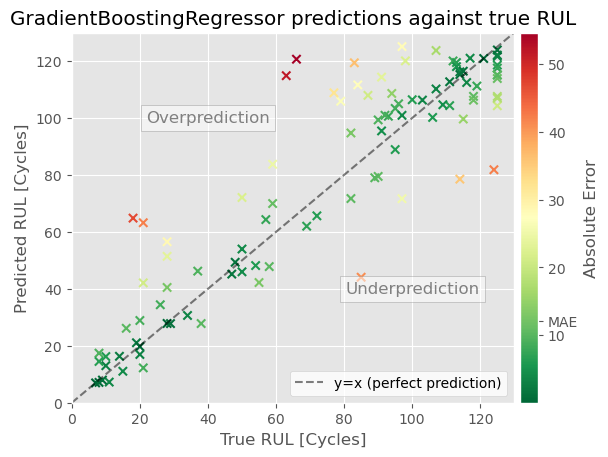

In [5]:
fig, ax = plt.subplots(figsize=fig_size(1, 0.5))

ax.scatter(test_labels, GBR_predictions, alpha=1, marker='x', c=np.abs(test_labels.to_numpy().flatten() - GBR_predictions), cmap='RdYlGn_r')
ax.plot([0, 130], [0, 130], color='black', alpha=0.5, linestyle='--', label='y=x (perfect prediction)')
ax.set_xlabel("True RUL [Cycles]")
ax.set_ylabel("Predicted RUL [Cycles]")
ax.set_title("GradientBoostingRegressor predictions against true RUL")

# add overprediction and underprediction regions
ax.text(40, 100, "Overprediction", fontsize=12, color='grey', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5, edgecolor='grey'))
ax.text(100, 40, "Underprediction", fontsize=12, color='grey', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5, edgecolor='grey'))
ax.set_ylim(0, 130)
ax.set_xlim(0, 130)

# colorbar
clb = plt.colorbar(ax.collections[0], label='Absolute Error', pad=0.01)
clb.ax.set_yticks([*clb.ax.get_yticks()[1:-1], MAE_test], labels=[*clb.ax.get_yticklabels()[1:-1], f'MAE'])


ax.legend(facecolor='white', loc='lower right')
plt.tight_layout()
plt.savefig("Output/boosting_predictions_vs_true_RUL.png", bbox_inches='tight')
plt.show()

In [6]:
# Write predictions to file
with open("Output/boosting_predictions.txt", "w") as f:
    for pred in GBR_predictions:
        f.write(f"{int(round(pred,0))}\n")